<a href="https://colab.research.google.com/github/jabranLmhani/Potholes-Detection-Deep-Learning-Yolov3/blob/main/Road_Analyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#YOLO You Only Look Once : Training Potholes Detector

> Bienvenu a Road-Analyzer 



La détection automatique des nids de poules par traitement d'images est un aspect important de l'entretien des routes. C'est également un problème difficile en raison de l'inhomogénéité des dommages de la route et de l'arrière-plan compliqué dans les images de la route. Ces dernières années, des méthodes basées sur des réseaux de neurones à convolution profonde ont été utilisées pour relever les défis de la détection et de la classification des dommages de la routes. tout au long de ce projet, nous proposons l'approche YOLO - Real-Time Object Detection pour relever ces défis. 

Dans cette approche, nous appliquons un seul réseau de neurones à l'image complète. Ce réseau divise l'image en régions et prédit les boîtes englobantes et les probabilités pour chaque région. Ces boîtes englobantes sont pondérées par les probabilités prédites.

## Installation de Darknet


In [ ]:
%cd /content
!rm -r darknet/
!git clone https://github.com/AlexeyAB/darknet.git
%cd darknet
import re
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
# !sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make
!chmod +x ./darknet


/content
rm: cannot remove 'darknet/': No such file or directory
Cloning into 'darknet'...
remote: Enumerating objects: 15424, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 15424 (delta 0), reused 1 (delta 0), pack-reused 15423
Receiving objects: 100% (15424/15424), 14.05 MiB | 7.92 MiB/s, done.
Resolving deltas: 100% (10364/10364), done.
/content/darknet
mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
tf.__version__

'1.15.2'

In [ ]:

def imShow(path):
  import cv2
  import matplotlib.pyplot as plt
  %matplotlib inline

  image = cv2.imread(path)
  height, width = image.shape[:2]
  resized_image = cv2.resize(image,(3*width, 3*height), interpolation = cv2.INTER_CUBIC)

  fig = plt.gcf()
  fig.set_size_inches(18, 10)
  plt.axis("off")
  
  plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))
  plt.show()
  
  


## Cloner un référentiel d'assistance
Cela facilite l'entrainement du model.
Afin de s'entraîner sur nos propres données, ce dépôt peut être utilisé comme modèle.
Des modifications de certains fichiers doivent être apportées en fonction de nos propres données.

In [ ]:
repo_url = 'https://github.com/GotG/yolotinyv3_medmask_demo'
import os
%cd /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
%rm -r {repo_dir_path}
!git clone {repo_url}
%cd {repo_dir_path}
os.rename(repo_dir_path, repo_dir_path.replace("medmask","potholes"))


/content
rm: cannot remove '/content/yolotinyv3_medmask_demo': No such file or directory
Cloning into 'yolotinyv3_medmask_demo'...
remote: Enumerating objects: 1733, done.
remote: Total 1733 (delta 0), reused 0 (delta 0), pack-reused 1733
Receiving objects: 100% (1733/1733), 208.88 MiB | 14.10 MiB/s, done.
Resolving deltas: 100% (120/120), done.
Checking out files: 100% (1537/1537), done.
/content/yolotinyv3_medmask_demo


### Configurations

Le dossier `obj` contient à la fois les images ET les annotations associées au format yolo.


* le fichier 'obj.data' contient les chemins des fichiers utilisés par Darknet et le nombre de classes pour former le modèle yolo.

* le fichier 'obj.names' contient les étiquettes des objets à détecter. le nombre d'objets donne le nombre de classes dans le fichier 'obj.data'.

* le train.txt contient le chemin vers chaque image à utiliser dans la formation. de même, valid.txt et test.txt contiennent le chemin d'accès à chaque image pour validation et test. lorsqu'il n'y a pas beaucoup d'images disponibles pour la formation (quelques centaines), utilisez toutes les images pour la formation pour de meilleures performances du modèle.

* les yolov4-tiny.conv.29 sont les poids COCO pré-entraînés

* le yolov4-tiny_obj.cfg est le petit fichier de configuration yolov4 qui indique à Darknet les paramètres et la structure du modèle

Nous pouvons donc voir que tous ces fichiers sont modifiés en fonction de nos propres données.


## Commençons par les images et les annotations
Nous copions les images sur notre lecteur Google dans un dossier

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

## REMOVE THIS TO USE YOUR OWN IMAGES
if (True):
  #remove the obj folder
  !rm -rf /content/yolotinyv3_potholes_demo/obj
  #copy images to obj folder
  #this can take a few minutes depending on dataset size. 
  !cp -rf '/content/drive/My Drive/datasets/potholes_dataset/' '/content/yolotinyv3_potholes_demo/obj'

Mounted at /content/drive


## Nous Remplaçons les étiquettes dans obj.names par nos étiquettes actuelles

In [ ]:
labels_path = '/content/yolotinyv3_potholes_demo/obj.names'
#make a list of your labels
labels = ['Fissure | Trace des roues','Fissure | Jointure de construction','Fissure | Interval égal','Fissure | Jointure de construction','Fissure | Alligator crack','Affaissement | Nid de poule','Passage pour piétons','Ligne blanche']


with open(labels_path, 'w') as f:

    f.write('\n'.join(labels))

#check that the labels file is correct
!cat /content/yolotinyv3_potholes_demo/obj.names

Fissure | Trace des roues
Fissure | Jointure de construction
Fissure | Interval égal
Fissure | Jointure de construction
Fissure | Alligator crack
Affaissement | Nid de poule
Passage pour piétons
Ligne blanche

## On modifie le nombre de classes dans obj.data.

> Bloc en retrait


Les chemins sont relatifs, donc aucun changement tant que la structure de dossier/fichier/les noms ne sont pas modifiés.

In [ ]:
import re
objdata = '/content/yolotinyv3_potholes_demo/obj.data'
with open(objdata) as f:
    s = f.read()

#the number of classes is equal to the number of labels
num_classes = len(labels)   
s = re.sub('classes = \d*','classes = ' + str(num_classes),s)

with open(objdata, 'w') as f:
  f.write(s)
!cat /content/yolotinyv3_potholes_demo/obj.data

classes= 8
train  = /content/yolotinyv3_potholes_demo/train.txt
valid  = /content/yolotinyv3_potholes_demo/valid.txt
names = /content/yolotinyv3_potholes_demo/obj.names
backup = backup/

## Nous devons maintenant créer un fichier train.txt, valid.txt et test.txt pour nos images à partir du dossier `obj`.
Nous allons utiliser un script qui divise les images en fonction d'un pourcentage spécifié et les écrit dans les fichiers train.txt, valid.txt et test.txt.

In [ ]:
#in this case we use 85 percent of the images for training
#10 percent for validation, 5 for testing.
#as the dataset is small, one can use 90 percent for training and split the rest
#for validation/testing as desired.
#double clicking on the train or test text files will open the file in a new
#tab in colab and display the content.
!python3 folder2textYolo.py 85 10 /content/yolotinyv3_potholes_demo/obj

Your image file extension is: .jpg
Number of images: 585
Number of images used for training 498
Number of images used for validation 58
Number of images used for testing 29


## La dernière chose que nous devons changer est le fichier yolov3-tiny_obj.cfg.


In [ ]:
!head -n 24 /content/yolotinyv3_potholes_demo/yolov3-tiny_obj.cfg 


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 4000
policy=steps
steps=3200,3600
scales=.1,.1



### Configuration justifiee:
* Le paramètre de Batch détermine la taille du lot. Celui-ci reste généralement à 64.
* Les subdivisions déterminent le nombre d'images chargées en mémoire. Un nombre plus petit se traduit par une formation plus rapide. Nous utiliserons 12. Si une erreur de manque de mémoire CUDA est déclenchée, les subdivisions doivent être augmentées à 16, 24, 32 ou un autre nombre. (64 est le maximum) À moins de s'entraîner avec une résolution supérieure à 416, il ne devrait y avoir aucun problème avec 12.
* La largeur et la hauteur sont par défaut à 416. Une autre résolution que l'on peut essayer est 320 ou 608.
* Le paramètre suivant qui nous intéresse est max_batches. Cela détermine la durée du processus de formation. Sa valeur doit être au moins d'environ 2000 pour chaque classe utilisée. Donc pour 3 classes, au moins 6000.
* Les pas sont calculés en fonction de max_batches. La première valeur est 0,8 * max_batches et la seconde valeur 0,9 * max_batches. Dans ce cas, il s'agit de 8000 * 0,8 et 8000 * 0,9.

References :
https://github.com/AlexeyAB/darknet#how-to-train-to-detect-your-custom-objects





### Modifions les paramètres

In [ ]:
# set the number of max_batches - min 2000 per class:
max_batch=16000
# calculate the 2 steps values:
step1 = 0.8 * max_batch
step2 = 0.9 * max_batch

# we also need to adjust the number of classes and a parameter called filter size 
# that are both is inside the model structure

# num_classes = len(labels)
num_filters = (num_classes + 5) * 3


cfg_file = '/content/yolotinyv3_potholes_demo/yolov3-tiny_obj.cfg'
# cfg_file = '/content/yolotinyv3_potholes_demo/yolov4-tiny.cfg'

with open(cfg_file) as f:
    s = f.read()
# (re.sub('[a-z]*@', 'ABC@', s))
s = re.sub('max_batches = \d*','max_batches = '+str(max_batch),s)
s = re.sub('steps=\d*,\d*','steps='+"{:.0f}".format(step1)+','+"{:.0f}".format(step2),s)
s = re.sub('classes=\d*','classes='+str(num_classes),s)
s = re.sub('pad=1\nfilters=\d*','pad=1\nfilters='+"{:.0f}".format(num_filters),s)
# pad=1\nfilters=\d\d
# s = re.sub('CUDNN=0','CUDNN=1',s)
# s = re.sub('OPENCV=0','OPENCV=1',s)

with open(cfg_file, 'w') as f:
  # s = re.sub('GPU=0','GPU=1',s)
  f.write(s)



Visualison la Config. Pour verifier

In [ ]:
!head -n 24 /content/yolotinyv3_potholes_demo/yolov3-tiny_obj.cfg 


[net]
# Testing
#batch=1
#subdivisions=1
# Training
batch=64
subdivisions=16
width=416
height=416
channels=3
momentum=0.9
decay=0.0005
angle=0
saturation = 1.5
exposure = 1.5
hue=.1

learning_rate=0.001
burn_in=1000
max_batches = 16000
policy=steps
steps=12800,14400
scales=.1,.1



On check le nombre de classes

In [ ]:
!tail -n 64 /content/yolotinyv3_potholes_demo/yolov3-tiny_obj.cfg 

stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=39
activation=linear



[yolo]
mask = 3,4,5
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=8
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1

[route]
layers = -4

[convolutional]
batch_normalize=1
filters=128
size=1
stride=1
pad=1
activation=leaky

[upsample]
stride=2

[route]
layers = -1, 8

[convolutional]
batch_normalize=1
filters=256
size=3
stride=1
pad=1
activation=leaky

[convolutional]
size=1
stride=1
pad=1
filters=39
activation=linear

[yolo]
mask = 1,2,3
anchors = 10,14,  23,27,  37,58,  81,82,  135,169,  344,319
classes=8
num=6
jitter=.3
ignore_thresh = .7
truth_thresh = 1
random=1


# Entraînement du modèle Tiny Yolo


* les fichiers qui se terminent par 1 000, 2 000, etc. sont des poids enregistrés tous les 1 000 lots
* le fichier des meilleurs poids sont les poids qui ont donné les meilleurs résultats pendant l'entraînement
* le fichier des poids finaux contient les poids finaux à la fin de la formation





## Début Entraînement


In [ ]:
%cd /content/darknet/

/content/darknet


In [ ]:
!./darknet detector train /content/yolotinyv3_potholes_demo/obj.data /content/yolotinyv3_potholes_demo/yolov3-tiny_obj.cfg /content/yolotinyv3_potholes_demo/yolov3-tiny.conv.15 -dont_show -ext_output -map

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 Prepare additional network for mAP calculation...
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     

# On verifie la performence du model
Les métriques s'exécutent sur les images de validation, elles peuvent donc ne pas être entièrement représentatives, uniquement indicatives

In [ ]:
!./darknet detector map /content/yolotinyv3_potholes_demo/obj.data /content/yolotinyv3_potholes_demo/yolov3-tiny_obj.cfg "/content/darknet/backup/yolov3-tiny_obj_best.weights" -points 0

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 co

## Run detection on an image. I choose one of the test images from test.txt

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, GPU count: 1  
 OpenCV version: 3.2.0
 0 : compute_capability = 600, cudnn_half = 0, GPU: Tesla P100-PCIE-16GB 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     16       3 x 3/ 1    416 x 416 x   3 ->  416 x 416 x  16 0.150 BF
   1 max                2x 2/ 2    416 x 416 x  16 ->  208 x 208 x  16 0.003 BF
   2 conv     32       3 x 3/ 1    208 x 208 x  16 ->  208 x 208 x  32 0.399 BF
   3 max                2x 2/ 2    208 x 208 x  32 ->  104 x 104 x  32 0.001 BF
   4 conv     64       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  64 0.399 BF
   5 max                2x 2/ 2    104 x 104 x  64 ->   52 x  52 x  64 0.001 BF
   6 conv    128       3 x 3/ 1     52 x  52 x  64 ->   52 x  52 x 128 0.399 BF
   7 max                2x 2/ 2     52 x  52 x 128 ->   26 x  26 x 128 0.000 BF
   8 co

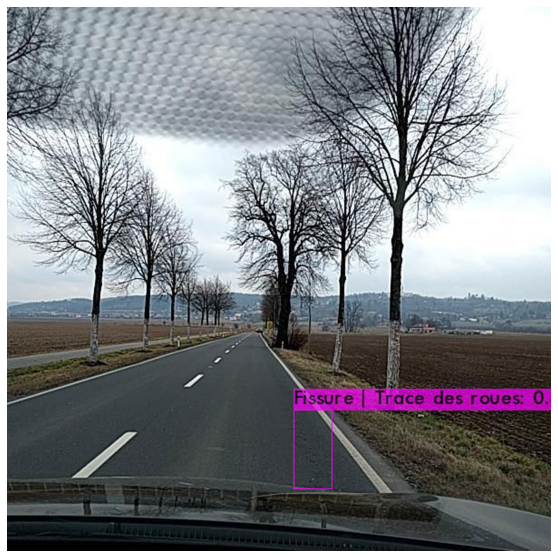

In [ ]:
!./darknet detector test /content/yolotinyv3_potholes_demo/obj.data  /content/yolotinyv3_potholes_demo/yolov3-tiny_obj.cfg  "/content/darknet/backup/yolov3-tiny_obj_best.weights" /content/yolotinyv3_potholes_demo/obj/898.jpg -ext_output
imShow('predictions.jpg')

On enregistre les meilleurs poids sur le drive : 


In [ ]:
!cp /content/darknet/backup/yolov3-tiny_obj_best.weights  '/content/drive/My Drive/Weights/Train1'

###On passe pour l'application android : Road-Analyzer
